In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
print(device)
dtype = torch.float32

cuda


In [3]:
# Importing MNIST train and test data
train_data = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
print(len(train_data), len(test_data))
print(train_data[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


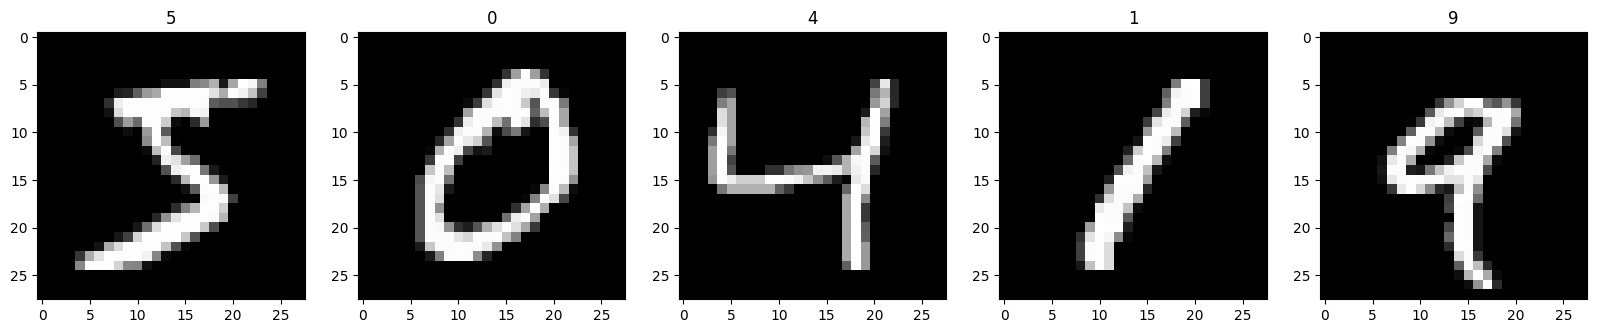

In [5]:
# Visualizing some samples
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(train_data[i][0].squeeze().numpy(), cmap='gray')
    ax[i].set_title(train_data[i][1])

In [6]:
class MyModel(nn.Module):
    def __init__ (self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(hidden_dim*7*7, output_dim)
        )

    def forward(self, x):
        return self.main(x)


For Untargetted FGSM Attack:


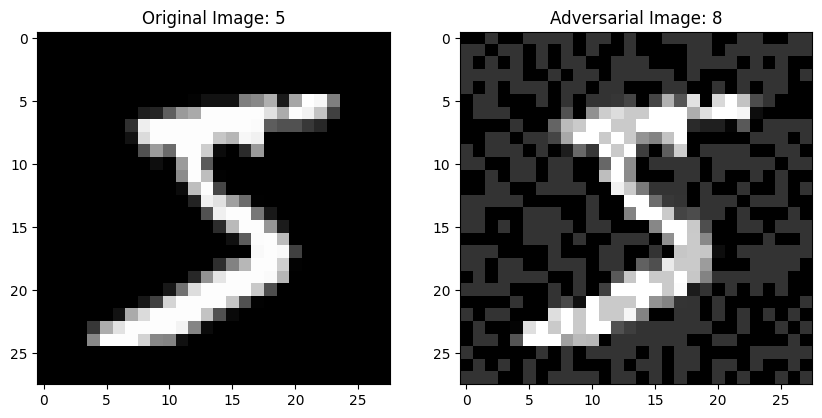

Loss(x, y_original) = 2.4101929664611816, Loss(x_adv, y_original) = 2.5085065364837646, Loss(x_adv, y_changed) = 2.205547571182251
################################################################################
For Targetted FGSM Attack:


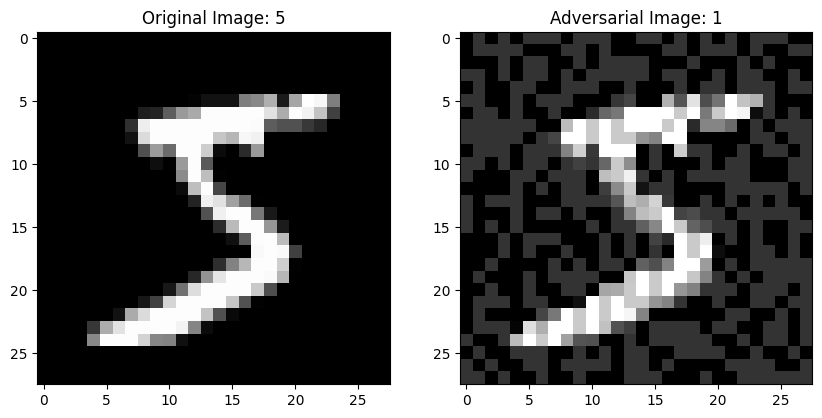

Loss(x, y_original) = 2.418668746948242, Loss(x_adv, y_original) = 2.4048349857330322, Loss(x_adv, y_changed) = 2.4176383018493652
For Untargetted PGD Attack:


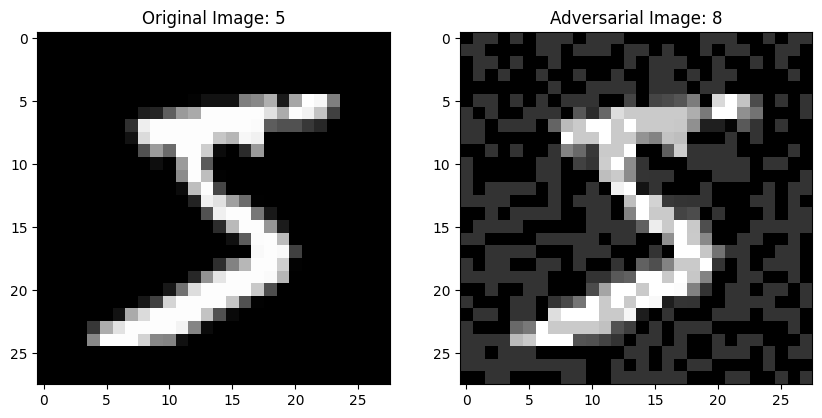

Loss(x, y_original) = 2.252608060836792, Loss(x_adv, y_original) = 2.4048349857330322, Loss(x_adv, y_changed) = 2.3779983520507812
For Targetted PGD Attack:


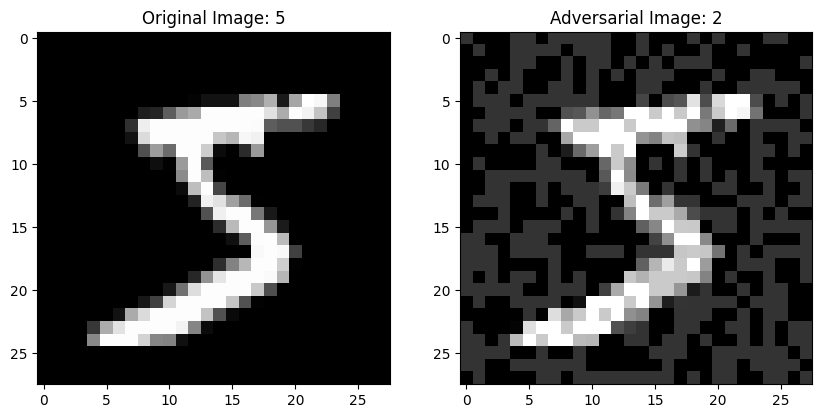

Loss(x, y_original) = 2.3318982124328613, Loss(x_adv, y_original) = 2.3922502994537354, Loss(x_adv, y_changed) = 2.2155113220214844


In [7]:
sample_img1 = train_data[0][0].unsqueeze(0)
sample_img2 = train_data[2][0].unsqueeze(0)
sample_img3 = train_data[4][0].unsqueeze(0)
sample_img4 = train_data[6][0].unsqueeze(0)
model1 = MyModel(1, 32, 10).to(device)
model2 = MyModel(1, 32, 10).to(device)
model3 = MyModel(1, 32, 10).to(device)
model4 = MyModel(1, 32, 10).to(device)

loader = DataLoader(train_data, batch_size=1 ,transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))


e = 0.2

# Applying untargetted_fgsm attack
x,y = next(iter(loader))
x, y = x.to(device), y.to(device)
x.requires_grad = True
scores1 = model1(x)
loss = F.cross_entropy(scores1, y)
model1.zero_grad()
loss.backward()
x_grad = x.grad.data
x_adv = x + e * x_grad.sign()
x_adv = torch.clamp(x_adv, 0, 1)
scores2 = model1(x_adv)
print("For Untargetted FGSM Attack:")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x.squeeze().detach().cpu().numpy(), cmap='gray')
ax[0].set_title(f"Original Image: {y.item()}")
ax[1].imshow(x_adv.squeeze().detach().cpu().numpy(), cmap='gray')
ax[1].set_title(f"Adversarial Image: {scores2.argmax(1).item()}")
plt.show()
print(f"Loss(x, y_original) = {F.cross_entropy(scores1, y)}, Loss(x_adv, y_original) = {F.cross_entropy(scores2, y)}, Loss(x_adv, y_changed) = {F.cross_entropy(scores2, scores2.argmax(1))}") 
print("################################################################################")

# Applying targetted_fgsm attack
x,y = next(iter(loader))
x = x.to(device=device, dtype=dtype)
y = y.to(device=device, dtype=torch.long)
target_label = torch.tensor([1]).to(device=device, dtype=torch.long)
x.requires_grad = True
scores = model2(x)
loss = F.cross_entropy(scores, target_label)
model2.zero_grad()
loss.backward()
x_grad = x.grad.data
# Perturb the input with FGSM
x_adv = x + e * x_grad.sign()
x_adv = torch.clamp(x_adv, 0, 1) 
scores_adv = model2(x_adv)
print("For Targetted FGSM Attack:")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x.squeeze().detach().cpu().numpy(), cmap='gray')
ax[0].set_title(f"Original Image: {y.item()}")
ax[1].imshow(x_adv.squeeze().detach().cpu().numpy(), cmap='gray')
ax[1].set_title(f"Adversarial Image: {target_label.item()}")
plt.show()
print(f"Loss(x, y_original) = {F.cross_entropy(scores, y)}, Loss(x_adv, y_original) = {F.cross_entropy(scores_adv, y)}, Loss(x_adv, y_changed) = {F.cross_entropy(scores_adv, target_label)}")

#Applying untargetted_pgd attack
x,y = next(iter(loader))
x = x.to(device=device, dtype=dtype)
y = y.to(device=device, dtype=torch.long)
x.requires_grad = True
for i in range(20):
    scores = model3(x)
    loss = F.cross_entropy(scores, y)
    model3.zero_grad()
    loss.backward()
    x_grad = x.grad.data
    x_adv = x + e * x_grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
_, preds = scores.max(1)
print("For Untargetted PGD Attack:")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x.squeeze().detach().cpu().numpy(), cmap='gray')
ax[0].set_title(f"Original Image: {y.item()}")
ax[1].imshow(x_adv.squeeze().detach().cpu().numpy(), cmap='gray')
ax[1].set_title(f"Adversarial Image: {preds.item()}")
plt.show()
print(f"Loss(x, y_original) = {F.cross_entropy(scores, y)}, Loss(x_adv, y_original) = {F.cross_entropy(scores_adv, y)}, Loss(x_adv, y_changed) = {F.cross_entropy(scores_adv, preds)}")

#Applying targetted_pgd attack
x,y = next(iter(loader))
x = x.to(device=device, dtype=dtype)
y = y.to(device=device, dtype=torch.long)
target_label = torch.tensor([1]).to(device=device, dtype=torch.long)
for i in range(20):
    x.requires_grad = True
    scores = model4(x)
    loss = F.cross_entropy(scores, target_label)
    model4.zero_grad()
    loss.backward()
    x_grad = x.grad.data
    x_adv = x + e * x_grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
scores_adv = model4(x_adv)
_, preds = scores_adv.max(1)
print("For Targetted PGD Attack:")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x.squeeze().detach().cpu().numpy(), cmap='gray')
ax[0].set_title(f"Original Image: {y.item()}")
ax[1].imshow(x_adv.squeeze().detach().cpu().numpy(), cmap='gray')
ax[1].set_title(f"Adversarial Image: {preds.item()}")
plt.show()
print(f"Loss(x, y_original) = {F.cross_entropy(scores, target_label)}, Loss(x_adv, y_original) = {F.cross_entropy(scores_adv, target_label)}, Loss(x_adv, y_changed) = {F.cross_entropy(scores_adv, preds)}")


In [8]:
def check_acc(data, model, loss_fn):
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    with torch.no_grad():
        for x, y in data:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _,preds = scores.max(1)
            total_loss += loss_fn(scores, y).item()
            n_samples += preds.size(0)
            n_correct += (preds == y).sum()
            n_batches += 1
    acc = float(n_correct/n_samples)
    loss = float(total_loss/n_batches)
    return acc, loss


In [ ]:
def denorm(tensor):
    tensor = tensor * 0.3081 + 0.1307
    return tensor

## Adversarial Testing

In [9]:
def train_model(model, train_data, test_data, loss_fn, num_epochs=5, batch_size=64):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True ,transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        train_loss = 0
        for t, (x, y) in enumerate(train_loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            train_preds = model(x)
            loss = loss_fn(train_preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_acc, _ = check_acc(train_loader, model, loss_fn)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

def eval_model(model, test_data, loss_fn):
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False,transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))
    test_acc, test_loss = check_acc(test_loader, model, loss_fn)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')



def eval_untargetted_fgsm(model, test_data, loss_fn, e=0.1):
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False , transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    
    for x, y in test_loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            x.requires_grad = True
            scores = model(x)
            loss = loss_fn(scores, y)
            model.zero_grad()
            loss.backward()
            x_grad = x.grad.data
            x = denorm(x)
            x_adv = x + e * x_grad.sign()
            x_adv = torch.clamp(x_adv, 0, 1)
            out_adv = model(x_adv)
            _,preds = out_adv.max(1)
            total_loss += loss_fn(out_adv, y).item()
            n_samples += preds.size(0)
            n_correct += (preds == y).sum()
            n_batches += 1
    acc = float(n_correct/n_samples)
    loss = float(total_loss/n_batches)
    print(f'Untargetted FGSM Test Loss: {loss:.4f}, Untargetted FGSM Test Acc: {acc:.4f}')
    return acc

# write code for targetted fgsm attack
def eval_targeted_fgsm(model, test_data, loss_fn, target_label, e=0.1):
    test_loader = DataLoader(test_data, batch_size=20, shuffle=False,transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    target_label = target_label.to(device=device, dtype=torch.long)
    
    for x, y in test_loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            x.requires_grad = True
            scores = model(x)
            loss1 = loss_fn(scores, y)
            loss2 = loss_fn(scores, target_label)
            loss = loss1-loss2
            model.zero_grad()
            loss.backward()
            x_grad = x.grad.data
            x = denorm(x)
            x_adv = x + e * x_grad.sign()
            x_adv = torch.clamp(x_adv, 0, 1)
            out_adv = model(x_adv)
            _,preds = out_adv.max(1)
            total_loss += loss_fn(out_adv, y).item()
            n_samples += preds.size(0)
            n_correct += (preds == y).sum()
            n_batches += 1
    acc = float(n_correct/n_samples)
    loss = float(total_loss/n_batches)
    print(f'Targetted FGSM Test Loss: {loss:.4f}, Targetted FGSM Test Acc: {acc:.4f}')
    return acc
     
def eval_untargetted_pgd(model, test_data, loss_fn, e=0.1, a=0.01, num_iter=30):
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False , transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    
    for x, y in test_loader:
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        x_adv = x.clone().detach().requires_grad_(True)
        
        for t in range(num_iter):
            scores = model(x_adv)
            loss = loss_fn(scores, y)
            model.zero_grad()
            loss.backward()
            x_adv_grad = x_adv.grad.data
            x_adv = denorm(x_adv)
            x_adv = x_adv + a * x_adv_grad.sign()
            x_adv = torch.min(torch.max(x_adv, x - e), x + e)
            x_adv = torch.clamp(x_adv, 0, 1)
            x_adv = x_adv.detach().requires_grad_(True)
        
        scores_adv = model(x_adv)
        _, preds = scores_adv.max(1)
        
        total_loss += loss_fn(scores_adv, y).item()
        n_samples += preds.size(0)
        n_correct += (preds == y).sum().item()
        n_batches += 1
    
    acc = float(n_correct / n_samples)
    loss = float(total_loss / n_batches)
    print(f'Untargeted PGD Test Loss: {loss:.4f}, Untargeted PGD Test Acc: {acc:.4f}')
    return acc
     
def eval_targeted_pgd(model, test_data, loss_fn, target_label, e=0.1, a=0.01, num_iter=30):
    test_loader = DataLoader(test_data, batch_size=20, shuffle=False,transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    
    for x, y in test_loader:
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        target_label = target_label.to(device=device, dtype=torch.long)
        x_adv = x.clone().detach().requires_grad_(True)
        
        for t in range(num_iter):
            scores = model(x_adv)
            loss1 = loss_fn(scores, y)
            loss2 = loss_fn(scores, target_label)
            loss = loss1-loss2
            model.zero_grad()
            loss.backward()
            x_grad = x_adv.grad.data
            x_adv = denorm(x_adv)
            x_adv = x_adv + a * x_grad.sign()
            x_adv = torch.min(torch.max(x_adv, x - e), x + e)
            x_adv = torch.clamp(x_adv, 0, 1)
            x_adv = x_adv.detach().requires_grad_(True)
        
        scores_adv = model(x_adv)
        loss_adv = loss_fn(scores_adv, y)
        _, preds = scores_adv.max(1)
        
        total_loss += loss_adv.item()
        n_samples += preds.size(0)
        n_correct += (preds == y).sum().item()
        n_batches += 1
    
    acc = float(n_correct / n_samples)
    loss = float(total_loss / n_batches)
    print(f'Targeted PGD Test Loss: {loss:.4f}, Targeted PGD Test Acc: {acc:.4f}')
    return acc





In [12]:
test_model = MyModel(1, 32, 10).to(device=device)
loss_fn = nn.CrossEntropyLoss()
train_model(test_model, train_data, test_data, loss_fn, num_epochs=5)
print("################################################################################")
print("Clean Accuracy:")
eval_model(test_model, test_data, loss_fn)
print("################################################################################")


Epoch 0, Train Loss: 0.2175, Train Acc: 0.9747
Epoch 1, Train Loss: 0.0662, Train Acc: 0.9849
Epoch 2, Train Loss: 0.0494, Train Acc: 0.9880
Epoch 3, Train Loss: 0.0391, Train Acc: 0.9914
Epoch 4, Train Loss: 0.0332, Train Acc: 0.9896
################################################################################
Clean Accuracy:
Test Loss: 0.0400, Test Acc: 0.9861
################################################################################


In [13]:
test_model = MyModel(1, 32, 10).to(device=device)
loss_fn = nn.CrossEntropyLoss()

print("Adversarial Accuracies:")
U_FGSM_ACC = []
T_FGSM_ACC = []
U_PGD_ACC = []
T_PGD_ACC = []

for epsilon in [0.01, 0.05, 0.15, 0.25]:
    print("############################")
    print(f"Epsilon = {epsilon}")
    acc1 = eval_untargetted_fgsm(test_model, test_data, loss_fn, e=epsilon)
    acc2 =eval_targeted_fgsm(test_model, test_data, loss_fn, e = epsilon, target_label=torch.full((20,), 7))
    acc3 = eval_untargetted_pgd(test_model, test_data, loss_fn, e=epsilon, a=0.01, num_iter=30)
    acc4 = eval_targeted_pgd(test_model, test_data, loss_fn, target_label=torch.full((20,), 7), e=epsilon, a=0.002, num_iter=30)
    U_FGSM_ACC.append(acc1)
    T_FGSM_ACC.append(acc2)
    U_PGD_ACC.append(acc3)
    T_PGD_ACC.append(acc4)

Adversarial Accuracies:
############################
Epsilon = 0.01
Untargetted FGSM Test Loss: 2.3135, Untargetted FGSM Test Acc: 0.0284
Targetted FGSM Test Loss: 2.3109, Targetted FGSM Test Acc: 0.0334
Untargeted PGD Test Loss: 2.3139, Untargeted PGD Test Acc: 0.0278


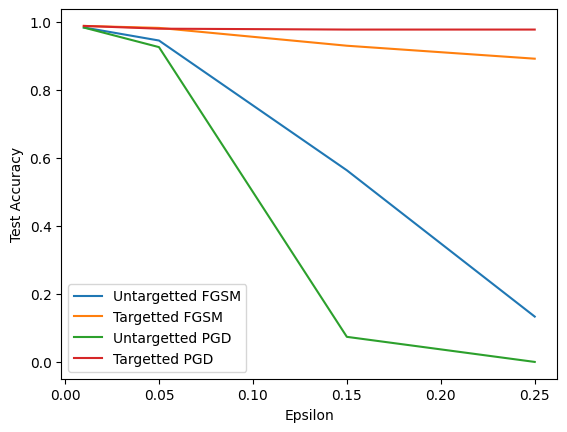

In [ ]:
# Plotting the variation of accuracies with epsilon
plt.plot([0.01,0.05, 0.15, 0.25], U_FGSM_ACC, label="Untargetted FGSM")
plt.plot([0.01,0.05, 0.15, 0.25], T_FGSM_ACC, label="Targetted FGSM")
plt.plot([0.01,0.05, 0.15, 0.25], U_PGD_ACC, label="Untargetted PGD")
plt.plot([0.01,0.05, 0.15, 0.25], T_PGD_ACC, label="Targetted PGD")
plt.xlabel("Epsilon")
plt.ylabel("Test Accuracy")
plt.legend()

## Adversarial Training


In [ ]:
# Now performing adversarial training on the model and checking the accuracies again

def adversarial_training(model, train_data, test_data, loss_fn, e=0.05, a=0.01, num_iter=20, num_epochs=10, batch_size=32):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        for t, (x, y) in enumerate(train_loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            x.requires_grad = True
            # 5% samples are adversarial
            if np.random.rand() < 0.05:
                for t in range(num_iter):
                    scores = model(x)
                    loss = loss_fn(scores, y)
                    model.zero_grad()
                    loss.backward()
                    x_grad = x.grad.data
                    x_adv = x + a * x_grad.sign()
                    x_adv = torch.min(torch.max(x_adv, x - e), x + e)
                    x_adv = torch.clamp(x_adv, 0, 1)
                    x = x_adv.detach().requires_grad_(True)
            train_preds = model(x)
            loss = loss_fn(train_preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss += loss.item()
        loss /= len(train_loader)
        train_acc, _ = check_acc(train_loader, model, loss_fn)
        print(f'Epoch {epoch}, Train Loss: {loss:.4f}, Train Acc: {train_acc:.4f}')
    
    print("Clean Accuracy:")
    eval_model(model, test_data, loss_fn)

In [ ]:
# Testing the adversarial training function
test_model = MyModel(1, 32, 10).to(device=device)
loss_fn = nn.CrossEntropyLoss()

adversarial_training(test_model, train_data, test_data, loss_fn, e=0.1, a=0.01, num_iter=30, num_epochs=10, batch_size=32)

Epoch 0, Train Loss: 0.0000, Train Acc: 0.9741
Epoch 1, Train Loss: 0.0001, Train Acc: 0.9770
Epoch 2, Train Loss: 0.0000, Train Acc: 0.9841
Epoch 3, Train Loss: 0.0003, Train Acc: 0.9863
Epoch 4, Train Loss: 0.0001, Train Acc: 0.9854
Epoch 5, Train Loss: 0.0000, Train Acc: 0.9882
Epoch 6, Train Loss: 0.0000, Train Acc: 0.9881
Epoch 7, Train Loss: 0.0001, Train Acc: 0.9898
Epoch 8, Train Loss: 0.0001, Train Acc: 0.9895
Epoch 9, Train Loss: 0.0000, Train Acc: 0.9898
Clean Accuracy:
Test Loss: 0.0422, Test Acc: 0.9883


In [ ]:
print("Adversarial Accuracies on Adversarially Trained Model:")
U_FGSM_ACC_adv = []
T_FGSM_ACC_adv = []
U_PGD_ACC_adv = []
T_PGD_ACC_adv = []
for epsilon in [0.01,0.05, 0.15, 0.25]:
    print("############################")
    print(f"Epsilon = {epsilon}")
    acc1 = eval_untargetted_fgsm(test_model, test_data, loss_fn, e=epsilon)
    acc2 = eval_targeted_fgsm(test_model, test_data, loss_fn, e = epsilon, target_label=torch.full((20,), 7))
    acc3 = eval_untargetted_pgd(test_model, test_data, loss_fn, e=epsilon, a=0.01, num_iter=30)
    acc4 = eval_targeted_pgd(test_model, test_data, loss_fn, target_label=torch.full((20,), 7), e=epsilon, a=0.002, num_iter=30)

    U_FGSM_ACC_adv.append(acc1)
    T_FGSM_ACC_adv.append(acc2)
    U_PGD_ACC_adv.append(acc3)
    T_PGD_ACC_adv.append(acc4)

Adversarial Accuracies on Adversarially Trained Model:
############################
Epsilon = 0.01
Untargetted FGSM Test Loss: 0.0488, Untargetted FGSM Test Acc: 0.9854
Targetted FGSM Test Loss: 0.0422, Targetted FGSM Test Acc: 0.9875
Untargeted PGD Test Loss: 0.0490, Untargeted PGD Test Acc: 0.9854
Targeted PGD Test Loss: 0.0422, Targeted PGD Test Acc: 0.9876
############################
Epsilon = 0.05
Untargetted FGSM Test Loss: 0.0765, Untargetted FGSM Test Acc: 0.9758
Targetted FGSM Test Loss: 0.0439, Targetted FGSM Test Acc: 0.9870
Untargeted PGD Test Loss: 0.0812, Untargeted PGD Test Acc: 0.9734
Targeted PGD Test Loss: 0.0444, Targeted PGD Test Acc: 0.9863
############################
Epsilon = 0.15
Untargetted FGSM Test Loss: 0.1759, Untargetted FGSM Test Acc: 0.9423
Targetted FGSM Test Loss: 0.0562, Targetted FGSM Test Acc: 0.9826
Untargeted PGD Test Loss: 0.2414, Untargeted PGD Test Acc: 0.9199
Targeted PGD Test Loss: 0.0453, Targeted PGD Test Acc: 0.9859
#####################

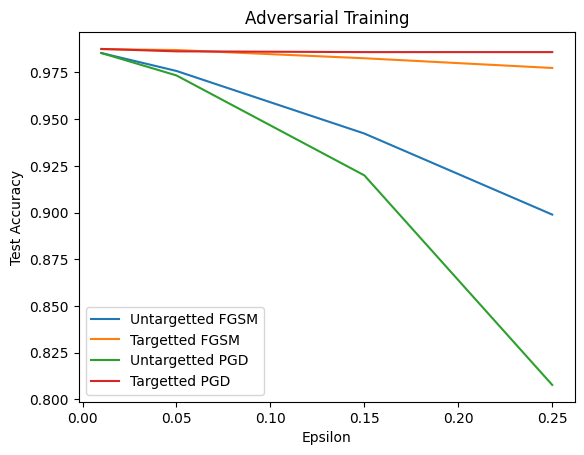

In [ ]:
# Plotting the variation of accuracies with epsilon
plt.plot([0.01,0.05, 0.15, 0.25], U_FGSM_ACC_adv, label="Untargetted FGSM")
plt.plot([0.01,0.05, 0.15, 0.25], T_FGSM_ACC_adv, label="Targetted FGSM")
plt.plot([0.01,0.05, 0.15, 0.25], U_PGD_ACC_adv, label="Untargetted PGD")
plt.plot([0.01,0.05, 0.15, 0.25], T_PGD_ACC_adv, label="Targetted PGD")
plt.xlabel("Epsilon")
plt.ylabel("Test Accuracy")
plt.title("Adversarial Training")
plt.legend()
plt.show()
